In [1]:
import os
import numpy as np
import torch
import torch.nn.functional as F
import SimpleITK as sitk
import cv2

# -----------------------------
# 1. Conversion: MHA → NPZ (for inference only)
# -----------------------------
def mha_to_npz_for_inference(mha_path, out_path,
                             target_size=(281, 372),
                             scale_lo=1, scale_hi=99):
    """Convert one .mha (no mask) to .npz for classification inference."""
    # load mha
    img = sitk.ReadImage(mha_path)
    img_np = sitk.GetArrayFromImage(img).astype(np.float32)   # [T,H,W]

    # resize to target size
    H, W = target_size
    img_small = np.stack([cv2.resize(fr, (W, H), interpolation=cv2.INTER_AREA)
                          for fr in img_np], 0)

    # robust intensity scaling
    lo_v, hi_v = np.percentile(img_small, [scale_lo, scale_hi])
    img_u8 = ((img_small - lo_v) / (hi_v - lo_v + 1e-6))
    img_u8 = np.clip(img_u8, 0, 1)
    img_u8 = (img_u8 * 255).astype(np.uint8)

    # save (only image, no labels)
    np.savez_compressed(out_path, image=img_u8)
    return out_path

# -----------------------------
# 2. Preprocessing
# -----------------------------
def letterbox_to_square_tensor(x: torch.Tensor, size=224) -> torch.Tensor:
    """Pad non-square frame to square, then resize to (size,size)."""
    is_batched = (x.dim() == 4)
    if not is_batched:
        x = x.unsqueeze(0)
    _, _, H, W = x.shape
    s = max(H, W)
    pad_h = (s - H) // 2; pad_w = (s - W) // 2
    x = F.pad(x, (pad_w, s-W-pad_w, pad_h, s-H-pad_h))
    x = F.interpolate(x, size=(size, size), mode="bilinear", align_corners=False)
    return x if is_batched else x.squeeze(0)

# -----------------------------
# 3. Hysteresis logic
# -----------------------------
def moving_average_safe(a: np.ndarray, w: int = 7) -> np.ndarray:
    if w <= 1: return a
    pad = w // 2
    ap = np.pad(a, (pad, pad), mode="edge")
    k = np.ones(w, dtype=np.float32) / w
    return np.convolve(ap, k, mode="valid")

def _segments_above_threshold(a: np.ndarray, low: float):
    on = a >= low; segs=[]; i=0; n=len(a)
    while i<n:
        if not on[i]: i+=1; continue
        j=i
        while j+1<n and on[j+1]: j+=1
        segs.append((i,j)); i=j+1
    return segs

def pick_best_index_from_plateaus(smoothed: np.ndarray, high: float, low: float, min_len: int) -> int:
    segs = _segments_above_threshold(smoothed, low)
    cand=[]
    for (s,e) in segs:
        seg = smoothed[s:e+1]
        if seg.max() >= high and (e-s+1) >= min_len:
            cand.append((s,e,seg.max()))
    if cand:
        cand.sort(key=lambda t: (t[2], (t[1]-t[0]+1)), reverse=True)
        s,e,_ = cand[0]
        return (s+e)//2
    return int(np.argmax(smoothed))

# -----------------------------
# 4. Classification Inference
# -----------------------------
@torch.no_grad()
def predict_probs_over_frames(npz_path, model, device="cuda", batch_size=64, image_size=224):
    d = np.load(npz_path, mmap_mode="r")
    frames = d["image"]
    Tn = len(frames)
    probs = np.zeros(Tn, dtype=np.float32)
    off=0
    while off < Tn:
        chunk = frames[off:off+batch_size]   # [B,H,W]
        x = torch.from_numpy(chunk).unsqueeze(1).float() / 255.0  # (B,1,H,W)
        x = letterbox_to_square_tensor(x, size=image_size)
        x = (x - 0.5) / 0.5   # normalize to [-1,1]
        x = x.to(device)
        logits = model(x)
        p = torch.softmax(logits, dim=1)[:,1].detach().cpu().numpy()
        probs[off:off+len(p)] = p
        off += len(p)
    return probs

@torch.no_grad()
def get_best_frame_idx(npz_path, model, device="cuda",
                       ma_window=11, high=0.9, low=0.8, min_run=5):
    probs = predict_probs_over_frames(npz_path, model, device=device)
    sm = moving_average_safe(probs, w=ma_window)
    best_idx = pick_best_index_from_plateaus(sm, high=high, low=low, min_len=min_run)
    return best_idx, sm[best_idx], probs, sm

# -----------------------------
# 5. End-to-End API
# -----------------------------
def classify_mha_best_frame(mha_path, model, tmp_dir="workdir",
                            device="cuda", image_size=224):
    os.makedirs(tmp_dir, exist_ok=True)
    npz_path = os.path.join(tmp_dir, os.path.basename(mha_path).replace(".mha", ".npz"))

    # Step 1: convert mha → npz (no mask)
    npz_path = mha_to_npz_for_inference(mha_path, npz_path)

    # Step 2–4: run inference
    best_idx, best_score, probs, sm = get_best_frame_idx(npz_path, model, device=device)

    return {
        "best_frame_idx": int(best_idx),
        "best_score": float(best_score),
        "probs": probs,
        "smoothed": sm,
        "npz_path": npz_path
    }


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import amp
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Sampler
from tqdm import tqdm
import torchvision.models as models

class FrameClassifier(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        try:
            backbone = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        except:
            backbone = models.resnet50(pretrained=True)

        old = backbone.conv1
        new = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        with torch.no_grad():
            new.weight.copy_(old.weight.mean(dim=1, keepdim=True))
        backbone.conv1 = new

        backbone.fc = nn.Linear(backbone.fc.in_features, num_classes)
        self.backbone = backbone

    def forward(self, x): return self.backbone(x)

In [11]:
import os
import csv
from tqdm import tqdm
import torch

image_dir = r"D:/dataset/acouslic-ai-train-set/images/stacked_fetal_ultrasound"
device = "cuda"
tmp_dir = "workdir_cls"

# load model
model = FrameClassifier(num_classes=2).to(device)
state = torch.load(r"D:/acouslic-ai-cse4622/saved_weights/frame_cls_fold3.pth", map_location=device)
model.load_state_dict(state)
model.eval()

# get last 45 mha files
files = sorted([f for f in os.listdir(image_dir) if f.endswith(".mha")])
test_files = files[-45:]
print(f"Found {len(test_files)} test files")

results = []
for f in tqdm(test_files, desc="Inference"):
    mha_path = os.path.join(image_dir, f)
    out = classify_mha_best_frame(mha_path, model, tmp_dir=tmp_dir, device=device)
    print(f"{f} → best_frame_idx={out['best_frame_idx']}  score={out['best_score']:.3f}")
    results.append({
        "case_id": os.path.splitext(f)[0],
        "filename": f,
        "best_frame_idx": int(out["best_frame_idx"]),
        "score": float(out["best_score"]),
    })

# save results to CSV
csv_path = os.path.join(tmp_dir, "best_frames_last45.csv")
os.makedirs(tmp_dir, exist_ok=True)
with open(csv_path, "w", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["case_id","filename","best_frame_idx","score"])
    writer.writeheader()
    writer.writerows(results)

print(f"\nSaved best frame indices to {csv_path}")


Found 45 test files


Inference:   2%|▏         | 1/45 [00:04<03:14,  4.43s/it]

d42fb920-5df1-4341-93df-480c17355e44.mha → best_frame_idx=802  score=0.936


Inference:   4%|▍         | 2/45 [00:08<03:09,  4.41s/it]

d5471cfd-6090-4d42-9a95-67ccbfbf612e.mha → best_frame_idx=46  score=0.959


Inference:   7%|▋         | 3/45 [00:13<03:04,  4.40s/it]

d571d4e1-ff80-44b9-a481-07961c6a1208.mha → best_frame_idx=47  score=0.973


Inference:   9%|▉         | 4/45 [00:17<02:59,  4.39s/it]

d5c3cfee-53ac-4021-8c1b-098c189f630e.mha → best_frame_idx=482  score=0.958


Inference:  11%|█         | 5/45 [00:21<02:55,  4.39s/it]

d5f8c859-de93-4a50-b324-1ae4ad0267d4.mha → best_frame_idx=70  score=0.900


Inference:  13%|█▎        | 6/45 [00:26<02:51,  4.40s/it]

d624338f-d09b-4bda-bbc3-3fa417015d6b.mha → best_frame_idx=73  score=0.965


Inference:  16%|█▌        | 7/45 [00:30<02:46,  4.38s/it]

d77b6ece-da17-4f88-818c-0c7340b3e54f.mha → best_frame_idx=58  score=0.912


Inference:  18%|█▊        | 8/45 [00:35<02:42,  4.39s/it]

d812091a-3635-4d51-9290-6adb3aa8681e.mha → best_frame_idx=37  score=0.922


Inference:  20%|██        | 9/45 [00:39<02:36,  4.34s/it]

d8c3665a-4dc3-40ce-b716-f30aab365332.mha → best_frame_idx=608  score=0.887


Inference:  22%|██▏       | 10/45 [00:43<02:32,  4.34s/it]

db9d468d-cb20-4d5e-b059-31728f5950e6.mha → best_frame_idx=334  score=0.962


Inference:  24%|██▍       | 11/45 [00:47<02:26,  4.30s/it]

dc0cbbdf-e4bb-4de5-958a-10576129e440.mha → best_frame_idx=52  score=0.907


Inference:  27%|██▋       | 12/45 [00:52<02:21,  4.28s/it]

dc381d50-124d-4bc8-b504-9c9c3a3ae697.mha → best_frame_idx=51  score=0.971


Inference:  29%|██▉       | 13/45 [00:56<02:17,  4.31s/it]

dcdcb9a4-fec7-45a2-b2b7-a282f963c551.mha → best_frame_idx=627  score=0.949


Inference:  31%|███       | 14/45 [01:00<02:13,  4.31s/it]

de35b365-6308-4974-b2fc-976e26584810.mha → best_frame_idx=650  score=0.583


Inference:  33%|███▎      | 15/45 [01:05<02:08,  4.30s/it]

de45de1a-2482-4024-ac8b-c18c4834b379.mha → best_frame_idx=50  score=0.924


Inference:  36%|███▌      | 16/45 [01:09<02:05,  4.32s/it]

de93dac8-41e0-4b03-946e-0accda6010af.mha → best_frame_idx=803  score=0.898


Inference:  38%|███▊      | 17/45 [01:13<02:00,  4.29s/it]

de964751-ec9d-4c53-9da3-9d7f200987b1.mha → best_frame_idx=36  score=0.968


Inference:  40%|████      | 18/45 [01:17<01:53,  4.22s/it]

decd2d84-79a2-4239-b802-5afdf318e7e6.mha → best_frame_idx=46  score=0.948


Inference:  42%|████▏     | 19/45 [01:21<01:49,  4.20s/it]

e3670fa9-574c-4fbc-89af-f69aad63696d.mha → best_frame_idx=318  score=0.973


Inference:  44%|████▍     | 20/45 [01:26<01:44,  4.19s/it]

e5053a72-46f6-496d-8252-c8b531b5039b.mha → best_frame_idx=608  score=0.909


Inference:  47%|████▋     | 21/45 [01:30<01:40,  4.19s/it]

e5a2d914-a35c-4207-9bc8-5e5cee7dbfba.mha → best_frame_idx=470  score=0.962


Inference:  49%|████▉     | 22/45 [01:34<01:38,  4.27s/it]

e608e364-6898-442c-be0f-aea8d7735c15.mha → best_frame_idx=50  score=0.968


Inference:  51%|█████     | 23/45 [01:38<01:33,  4.26s/it]

e9025780-a9bb-4300-be4e-fb220e824646.mha → best_frame_idx=203  score=0.962


Inference:  53%|█████▎    | 24/45 [01:43<01:29,  4.28s/it]

e9043ff5-f8a4-4095-bc44-26232e1be011.mha → best_frame_idx=11  score=0.943


Inference:  56%|█████▌    | 25/45 [01:47<01:26,  4.34s/it]

ea2a8fbf-f7fe-43f4-9e0d-1da0ae9b1a0c.mha → best_frame_idx=306  score=0.952


Inference:  58%|█████▊    | 26/45 [01:52<01:22,  4.36s/it]

ea724ff0-9990-4557-ab53-16f2fe1f1c8f.mha → best_frame_idx=53  score=0.963


Inference:  60%|██████    | 27/45 [01:56<01:18,  4.39s/it]

ea86047a-bae4-464b-a2ed-015935bebb2a.mha → best_frame_idx=62  score=0.977


Inference:  62%|██████▏   | 28/45 [02:01<01:15,  4.45s/it]

ebadcfcb-a682-4493-8502-2adc194bba8c.mha → best_frame_idx=469  score=0.963


Inference:  64%|██████▍   | 29/45 [02:05<01:11,  4.48s/it]

ec65aa35-d54c-44da-80a4-883f631c345e.mha → best_frame_idx=170  score=0.907


Inference:  67%|██████▋   | 30/45 [02:10<01:07,  4.53s/it]

ee2e6220-b2f3-4c8e-9c85-f04ed0a6b6f7.mha → best_frame_idx=482  score=0.958


Inference:  69%|██████▉   | 31/45 [02:14<01:02,  4.50s/it]

eee8da44-8db7-4c9e-b52d-b6d461158a4e.mha → best_frame_idx=624  score=0.948


Inference:  71%|███████   | 32/45 [02:19<00:58,  4.48s/it]

f1fcabfc-f998-44c7-8420-c7a5ae5aaab7.mha → best_frame_idx=622  score=0.445


Inference:  73%|███████▎  | 33/45 [02:23<00:53,  4.47s/it]

f256d725-9b06-4a88-a6b5-f9eee0f050f4.mha → best_frame_idx=48  score=0.928


Inference:  76%|███████▌  | 34/45 [02:28<00:49,  4.46s/it]

f4488c3c-556e-43bd-95f9-ae4cbb7c7093.mha → best_frame_idx=633  score=0.948


Inference:  78%|███████▊  | 35/45 [02:32<00:44,  4.44s/it]

f4bebd1e-d3ca-4186-902a-2b6ef9391060.mha → best_frame_idx=43  score=0.890


Inference:  80%|████████  | 36/45 [02:36<00:39,  4.41s/it]

f5611c30-d04b-4691-9bd6-1e6de392a63c.mha → best_frame_idx=70  score=0.732


Inference:  82%|████████▏ | 37/45 [02:41<00:35,  4.41s/it]

f5a702f0-d759-4b53-8215-462e8145e638.mha → best_frame_idx=304  score=0.878


Inference:  84%|████████▍ | 38/45 [02:45<00:30,  4.35s/it]

f5e853b1-9465-40b0-a246-7d3f6cb94de7.mha → best_frame_idx=163  score=0.954


Inference:  87%|████████▋ | 39/45 [02:49<00:26,  4.35s/it]

f5e97e20-ad47-46e4-bf35-3f0c01ff51d0.mha → best_frame_idx=84  score=0.928


Inference:  89%|████████▉ | 40/45 [02:54<00:21,  4.33s/it]

f8039e25-4652-440c-9476-b425f3fccb22.mha → best_frame_idx=61  score=0.956


Inference:  91%|█████████ | 41/45 [02:58<00:17,  4.29s/it]

f9ba7ffd-bc66-4da6-b97d-1286d760a184.mha → best_frame_idx=57  score=0.961


Inference:  93%|█████████▎| 42/45 [03:02<00:12,  4.33s/it]

fc167d1b-045a-4057-936d-4862644af1f3.mha → best_frame_idx=86  score=0.968


Inference:  96%|█████████▌| 43/45 [03:07<00:08,  4.35s/it]

fc63df40-f6ca-4917-99ba-dbe4310a6d04.mha → best_frame_idx=612  score=0.965


Inference:  98%|█████████▊| 44/45 [03:11<00:04,  4.33s/it]

fdfd752d-2d83-4452-a3ba-97a626676334.mha → best_frame_idx=34  score=0.863


Inference: 100%|██████████| 45/45 [03:15<00:00,  4.35s/it]

fe236600-a41c-4d26-b4ea-6d3ff109cf41.mha → best_frame_idx=286  score=0.899

Saved best frame indices to workdir_cls\best_frames_last45.csv


In [12]:
# make_seg_npz_from_best_frames.py
import os, csv
from pathlib import Path
import numpy as np
import SimpleITK as sitk

# ---------- paths ----------
IMAGE_DIR    = Path(r"D:/dataset/acouslic-ai-train-set/images/stacked_fetal_ultrasound")
CLS_WORKDIR  = Path("workdir_cls")                   # has best_frames_last45.csv from your classifier
SEG_INPUTDIR = Path("workdir_seg_inputs")            # we'll write NPZs here
AC_CSV       = Path(r"D:/dataset/acouslic-ai-train-set/fetal_abdominal_circumferences_per_sweep.csvv")  # optional; set if you want ac_reference

SEG_INPUTDIR.mkdir(parents=True, exist_ok=True)

# ---------- optional AC helpers (matching your converter) ----------
import pandas as pd
def load_ac_csv(csv_path):
    return pd.read_csv(csv_path).set_index("uuid")

def get_reference_ac(ac_df, uuid):
    try:
        ac_row = ac_df.loc[uuid]
        ac_values = ac_row.filter(like='sweep_').dropna().values
        return float(ac_values[0]) if len(ac_values) > 0 else None
    except Exception:
        return None

ac_df = load_ac_csv(AC_CSV) if AC_CSV.exists() else None

# ---------- utils ----------
def read_mha(path: Path) -> np.ndarray:
    img = sitk.ReadImage(str(path))
    arr = sitk.GetArrayFromImage(img).astype(np.float32)  # [T,H,W]
    return arr, img

def normalize01(x: np.ndarray) -> np.ndarray:
    mn, mx = float(x.min()), float(x.max())
    if mx > mn: return (x - mn) / (mx - mn)
    return np.zeros_like(x, dtype=np.float32)

# ---------- main ----------
pred_csv = CLS_WORKDIR / "best_frames_last45.csv"
assert pred_csv.exists(), f"Missing: {pred_csv}"

written = []
with open(pred_csv, "r") as f:
    for row in csv.DictReader(f):
        uuid   = row["case_id"]
        fname  = row["filename"]
        best_i = int(row["best_frame_idx"])

        mha_path = IMAGE_DIR / fname
        if not mha_path.exists():
            print(f"⚠️ Missing MHA: {mha_path}; skipping")
            continue

        vol, itk_img = read_mha(mha_path)          # [T,H,W]
        T, H, W = vol.shape
        if not (0 <= best_i < T):
            print(f"⚠️ {fname}: best idx {best_i} out of range [0,{T-1}] — clamping")
            best_i = max(0, min(T-1, best_i))

        frame = normalize01(vol[best_i])           # (H,W) in [0,1]

        # match your segmentation NPZ schema:
        # keys: image [T,H,W] float32, mask [T,H,W] uint8, label [T] uint8,
        #       pixel_spacing float32, ac_reference float32, uuid str
        # For inference we don't have GT mask — store zeros; label=0.
        image_arr = frame[None, ...].astype(np.float32)   # T=1
        mask_arr  = np.zeros_like(image_arr, dtype=np.uint8)
        label_arr = np.zeros((1,), dtype=np.uint8)

        # pixel spacing: use your training default if unknown
        try:
            sx, sy, sz = itk_img.GetSpacing()
            # your pipeline used a fixed 0.28; keep that for consistency
            pixel_spacing = np.float32(0.28)
        except Exception:
            pixel_spacing = np.float32(0.28)

        ac_reference = np.float32(get_reference_ac(ac_df, uuid) if ac_df is not None else np.nan)

        out_npz = SEG_INPUTDIR / f"{uuid}.npz"
        np.savez_compressed(
            out_npz,
            image=image_arr,
            mask=mask_arr,
            label=label_arr,
            pixel_spacing=pixel_spacing,
            ac_reference=ac_reference,
            uuid=uuid,
            best_frame_idx=np.int32(best_i)  # handy metadata
        )
        written.append(out_npz)
        print(f"✅ wrote {out_npz.name}  (image shape={image_arr.shape})")

print(f"\nDone. Wrote {len(written)} segmentation NPZs to {SEG_INPUTDIR}")


✅ wrote d42fb920-5df1-4341-93df-480c17355e44.npz  (image shape=(1, 562, 744))
✅ wrote d5471cfd-6090-4d42-9a95-67ccbfbf612e.npz  (image shape=(1, 562, 744))
✅ wrote d571d4e1-ff80-44b9-a481-07961c6a1208.npz  (image shape=(1, 562, 744))
✅ wrote d5c3cfee-53ac-4021-8c1b-098c189f630e.npz  (image shape=(1, 562, 744))
✅ wrote d5f8c859-de93-4a50-b324-1ae4ad0267d4.npz  (image shape=(1, 562, 744))
✅ wrote d624338f-d09b-4bda-bbc3-3fa417015d6b.npz  (image shape=(1, 562, 744))
✅ wrote d77b6ece-da17-4f88-818c-0c7340b3e54f.npz  (image shape=(1, 562, 744))
✅ wrote d812091a-3635-4d51-9290-6adb3aa8681e.npz  (image shape=(1, 562, 744))
✅ wrote d8c3665a-4dc3-40ce-b716-f30aab365332.npz  (image shape=(1, 562, 744))
✅ wrote db9d468d-cb20-4d5e-b059-31728f5950e6.npz  (image shape=(1, 562, 744))
✅ wrote dc0cbbdf-e4bb-4de5-958a-10576129e440.npz  (image shape=(1, 562, 744))
✅ wrote dc381d50-124d-4bc8-b504-9c9c3a3ae697.npz  (image shape=(1, 562, 744))
✅ wrote dcdcb9a4-fec7-45a2-b2b7-a282f963c551.npz  (image shape=(

In [ ]:
# segment_from_seg_npz.py
import os, csv
from pathlib import Path
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import cv2
from tqdm import tqdm
import segmentation_models_pytorch as smp

# ---------- paths ----------
SEG_INPUTDIR = Path("workdir_seg_inputs")   # from script (1)
SEG_OUTDIR   = Path("workdir_seg")          # outputs here
SEG_WEIGHTS  = Path(r"D:/acouslic-ai-cse4622/saved_weights/best_unet_seg.pth")
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

# preprocessing / postprocessing
SEG_TARGET_HW = (256, 256)     # letterbox target used at inference
SEG_THRESHOLD = 0.5
POST_KEEP     = "largest+smooth"   # 'largest' or 'largest+smooth'
POST_SHAPE    = None               # None | 'ellipse' | 'circle'

SEG_OUTDIR.mkdir(parents=True, exist_ok=True)

# ---------- letterbox helpers ----------
from typing import Tuple
def letterbox_params(H:int, W:int, target_hw:Tuple[int,int]):
    th, tw = target_hw
    scale = min(th / H, tw / W)
    nh, nw = int(round(H * scale)), int(round(W * scale))
    pad_h = th - nh
    pad_w = tw - nw
    pad_top    = pad_h // 2
    pad_bottom = pad_h - pad_top
    pad_left   = pad_w // 2
    pad_right  = pad_w - pad_left
    return nh, nw, scale, (pad_left, pad_right, pad_top, pad_bottom)

def apply_letterbox(img_t: torch.Tensor, target_hw:Tuple[int,int]):
    # img_t: (1,H,W)
    _, H, W = img_t.shape
    nh, nw, scale, pads = letterbox_params(H, W, target_hw)
    th, tw = target_hw
    img_t = F.interpolate(img_t.unsqueeze(0), size=(nh, nw), mode="bilinear", align_corners=False).squeeze(0)
    pl, pr, pt, pb = pads
    img_t = F.pad(img_t, (pl, pr, pt, pb), value=0.0)  # (1,th,tw)
    return img_t, (H, W, nh, nw, scale, pads)

def undo_letterbox(mask_t: torch.Tensor, meta):
    H, W, nh, nw, scale, (pl, pr, pt, pb) = meta
    m = mask_t[..., pt:pt+nh, pl:pl+nw]
    m = F.interpolate(m.unsqueeze(0), size=(H, W), mode="nearest").squeeze(0)
    return m

# ---------- postprocess ----------
def largest_component(binary: np.ndarray, min_area: int = 0):
    binary = (binary > 0).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(binary, connectivity=8)
    if num <= 1: return binary
    areas = stats[1:, cv2.CC_STAT_AREA]
    max_i = 1 + np.argmax(areas)
    if min_area > 0 and stats[max_i, cv2.CC_STAT_AREA] < min_area:
        return np.zeros_like(binary, dtype=np.uint8)
    out = np.zeros_like(binary, dtype=np.uint8)
    out[labels == max_i] = 1
    return out

def fill_holes_and_smooth(binary: np.ndarray, k_close: int = 5, k_open: int = 3):
    binary = (binary > 0).astype(np.uint8)
    h, w = binary.shape
    ff = binary.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(ff, mask, seedPoint=(0,0), newVal=255)
    holes = (~ff.astype(bool) & ~binary.astype(bool)).astype(np.uint8)*255
    filled = (binary*255) | holes
    if k_close > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_close, k_close))
        filled = cv2.morphologyEx(filled, cv2.MORPH_CLOSE, k)
    if k_open > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_open, k_open))
        filled = cv2.morphologyEx(filled, cv2.MORPH_OPEN, k)
    return (filled > 0).astype(np.uint8)

def fit_best_shape(binary: np.ndarray, mode: str = "ellipse"):
    b = largest_component(binary)
    if b.max() == 0: return b
    cnts, _ = cv2.findContours(b.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not cnts: return b
    cnt = max(cnts, key=cv2.contourArea)
    H, W = b.shape
    canvas = np.zeros((H, W), dtype=np.uint8)
    if mode == "circle":
        (x, y), radius = cv2.minEnclosingCircle(cnt)
        cv2.circle(canvas, (int(x), int(y)), int(radius), 1, thickness=-1)
    else:
        if len(cnt) >= 5:
            ellipse = cv2.fitEllipse(cnt)
            cv2.ellipse(canvas, ellipse, 1, thickness=-1)
        else:
            (x, y), radius = cv2.minEnclosingCircle(cnt)
            cv2.circle(canvas, (int(x), int(y)), int(radius), 1, thickness=-1)
    return canvas

def postprocess_mask(prob_or_bin: np.ndarray, threshold=SEG_THRESHOLD, min_area_frac=0.002, keep=POST_KEEP, shape=POST_SHAPE):
    m = prob_or_bin if prob_or_bin.dtype in (np.uint8, np.bool_) else (prob_or_bin >= threshold).astype(np.uint8)
    H, W = m.shape
    m = largest_component(m, min_area=int(min_area_frac * H * W))
    if keep == "largest+smooth":
        m = fill_holes_and_smooth(m, k_close=5, k_open=3)
    if shape in ("circle", "ellipse"):
        m = fit_best_shape(m, mode=shape)
    return m.astype(np.uint8)

# ---------- model ----------
class UNetSeg(nn.Module):
    def __init__(self, encoder="resnet18", encoder_weights=None):
        super().__init__()
        self.unet = smp.Unet(
            encoder_name=encoder, encoder_weights=encoder_weights,
            in_channels=1, classes=1
        )
    def forward(self, x): return self.unet(x)

# ---------- run ----------
seg_model = UNetSeg(encoder="resnet18", encoder_weights=None).to(DEVICE)
state = torch.load(str(SEG_WEIGHTS), map_location=DEVICE)
seg_model.load_state_dict(state)
seg_model.eval()

manifest = []
npz_files = sorted([p for p in SEG_INPUTDIR.iterdir() if p.suffix.lower()==".npz"])
print(f"Found {len(npz_files)} seg-NPZs in {SEG_INPUTDIR}")

for p in tqdm(npz_files, desc="Segment"):
    data = np.load(p, allow_pickle=True)
    img  = data["image"]     # [1,H,W], float32 in [0,1]
    uuid = str(data["uuid"]) if "uuid" in data else p.stem

    H, W = img.shape[1:]
    x = torch.from_numpy(img[0]).unsqueeze(0).float()  # (1,H,W)
    x_lb, meta = apply_letterbox(x, SEG_TARGET_HW)     # (1,th,tw)

    with torch.no_grad():
        xin = x_lb.unsqueeze(0).to(DEVICE)            # (1,1,th,tw)
        logits = seg_model(xin).squeeze(0).squeeze(0).detach().cpu().numpy()  # (th,tw)
        prob   = 1.0 / (1.0 + np.exp(-logits))

    bin_small      = (prob >= SEG_THRESHOLD).astype(np.uint8)
    bin_post_small = postprocess_mask(bin_small)

    m_small_t = torch.from_numpy(bin_post_small[None, ...]).float()   # (1,th,tw)
    m_orig_t  = undo_letterbox(m_small_t, meta)                       # (1,H,W)
    m_orig    = (m_orig_t.squeeze(0).numpy() > 0.5).astype(np.uint8)

    case_dir = SEG_OUTDIR / uuid
    case_dir.mkdir(parents=True, exist_ok=True)
    np.save(case_dir / "mask_prob.npy", prob)
    cv2.imwrite(str(case_dir / "mask_post.png"), m_orig * 255)

    # overlay (red) on uint8 version of the frame
    fr_u8 = (img[0] * 255).clip(0,255).astype(np.uint8)
    fr_u8 = (fr_u8 - fr_u8.min()) / (fr_u8.max() - fr_u8.min() + 1e-6) * 255
    fr_u8 = fr_u8.astype(np.uint8)
    color = cv2.cvtColor(fr_u8, cv2.COLOR_GRAY2BGR)
    over  = color.copy()
    over[m_orig > 0] = (0,0,255)
    out   = cv2.addWeighted(over, 0.6, color, 0.4, 0)
    cv2.imwrite(str(case_dir / "overlay.png"), out)

    manifest.append({
        "uuid": uuid,
        "seg_input": str(p),
        "mask_post": str(case_dir / "mask_post.png"),
        "overlay":   str(case_dir / "overlay.png")
    })

# write manifest
out_csv = SEG_OUTDIR / "seg_manifest.csv"
with open(out_csv, "w", newline="") as f:
    w = csv.DictWriter(f, fieldnames=["uuid","seg_input","mask_post","overlay"])
    w.writeheader()
    w.writerows(manifest)

print(f"\nDone. Outputs in: {SEG_OUTDIR}")
print(f"Manifest: {out_csv}")


c:\Users\User\anaconda3\envs\torch310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found 45 seg-NPZs in workdir_seg_inputs


Segment: 100%|██████████| 45/45 [00:01<00:00, 28.55it/s]


Done. Outputs in: workdir_seg
Manifest: workdir_seg\seg_manifest.csv


Classifier cases: 45


Segment ALL -> show best:   0%|          | 0/45 [00:00<?, ?it/s]C:\Users\User\AppData\Local\Temp\ipykernel_16952\4031998219.py:243: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):


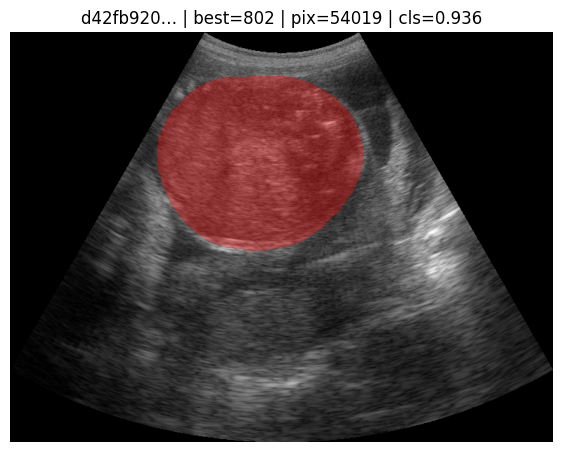

Segment ALL -> show best:   2%|▏         | 1/45 [00:08<06:15,  8.53s/it]

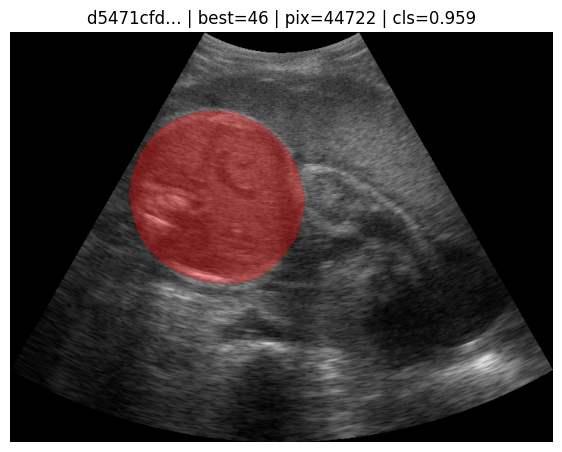

Segment ALL -> show best:   4%|▍         | 2/45 [00:17<06:13,  8.69s/it]

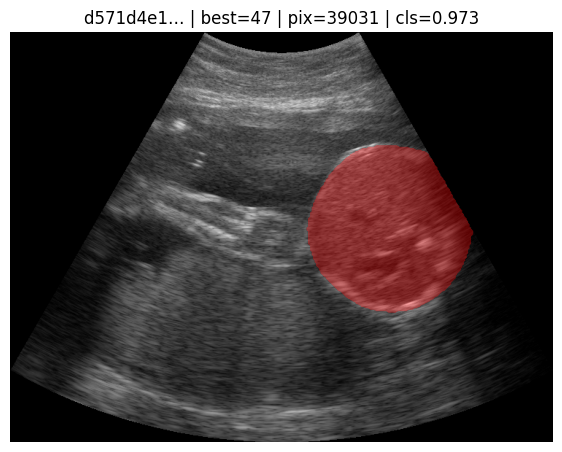

Segment ALL -> show best:   7%|▋         | 3/45 [00:25<06:03,  8.66s/it]

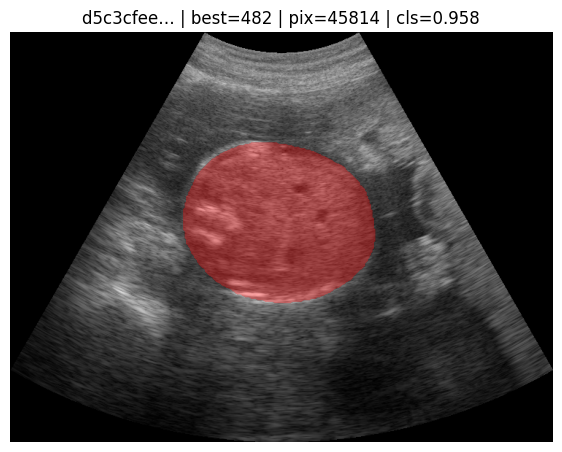

Segment ALL -> show best:   9%|▉         | 4/45 [00:34<05:53,  8.62s/it]

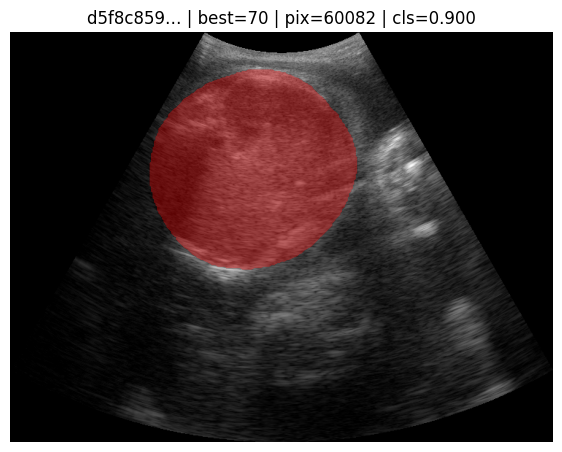

Segment ALL -> show best:  11%|█         | 5/45 [00:43<05:43,  8.59s/it]

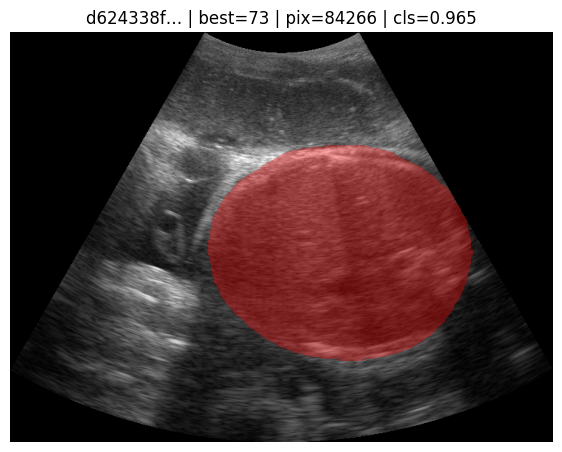

Segment ALL -> show best:  13%|█▎        | 6/45 [00:51<05:34,  8.58s/it]

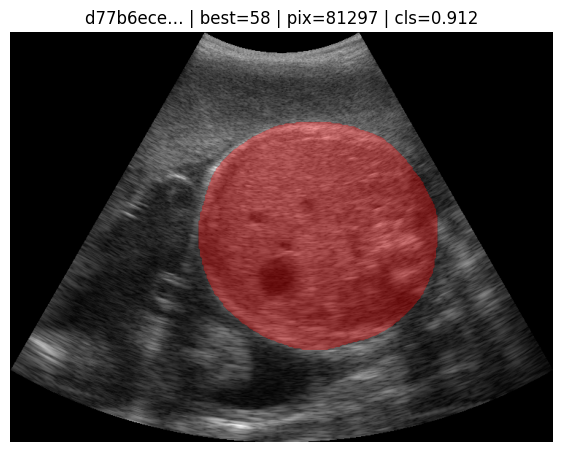

Segment ALL -> show best:  16%|█▌        | 7/45 [01:00<05:25,  8.56s/it]

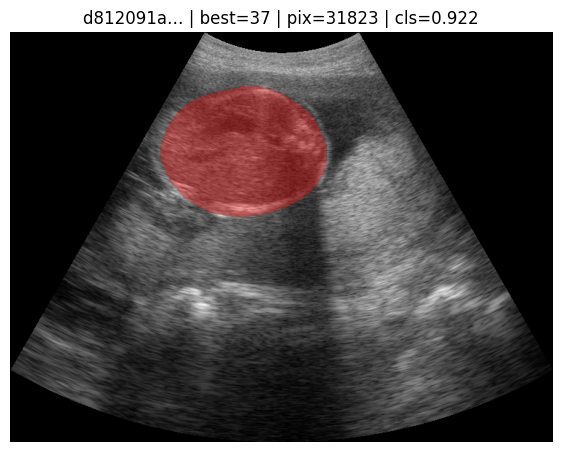

Segment ALL -> show best:  18%|█▊        | 8/45 [01:08<05:13,  8.49s/it]

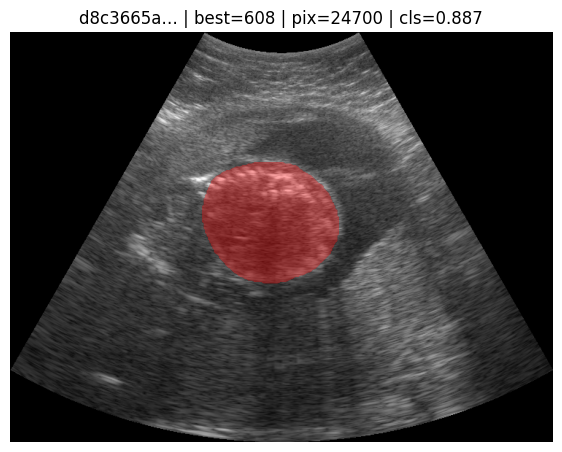

Segment ALL -> show best:  20%|██        | 9/45 [01:17<05:06,  8.52s/it]

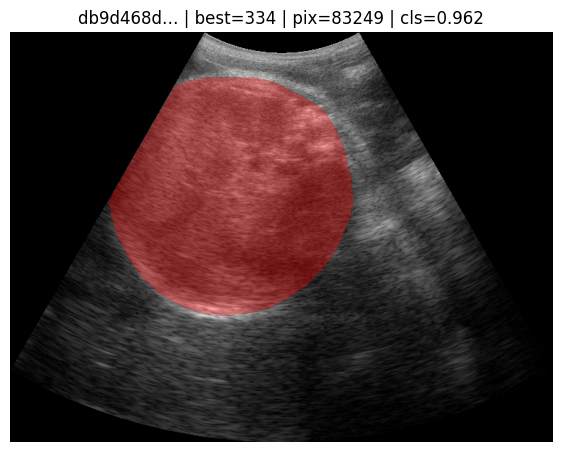

Segment ALL -> show best:  22%|██▏       | 10/45 [01:25<04:57,  8.50s/it]

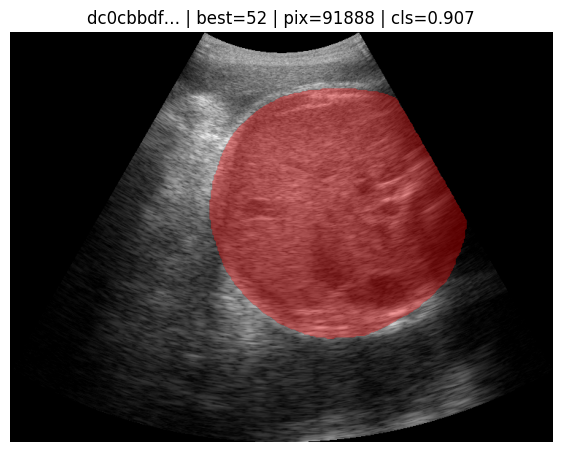

Segment ALL -> show best:  24%|██▍       | 11/45 [01:34<04:51,  8.56s/it]

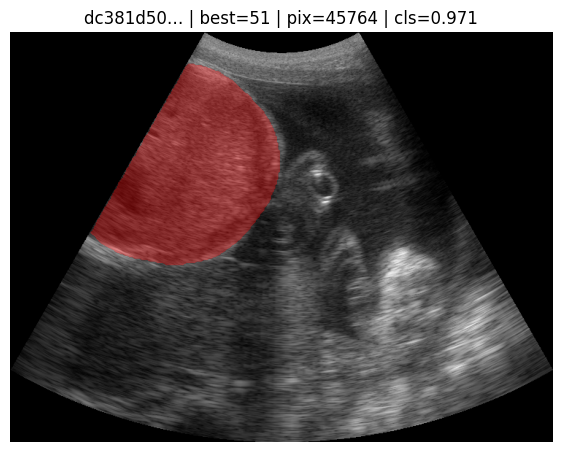

Segment ALL -> show best:  27%|██▋       | 12/45 [01:42<04:42,  8.55s/it]

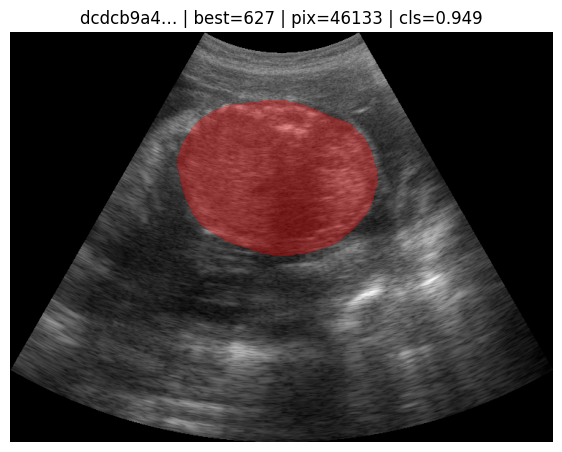

Segment ALL -> show best:  29%|██▉       | 13/45 [01:51<04:33,  8.55s/it]

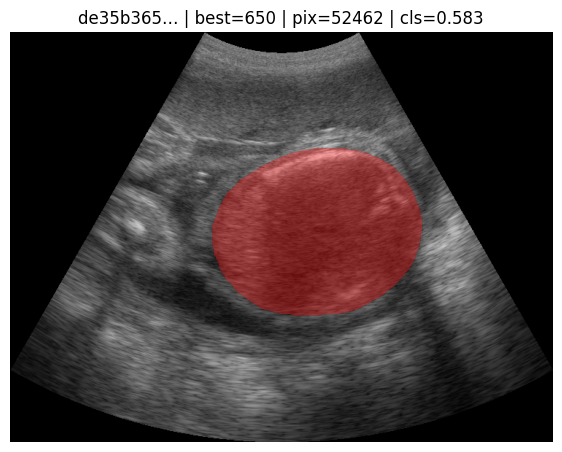

Segment ALL -> show best:  31%|███       | 14/45 [01:59<04:24,  8.54s/it]

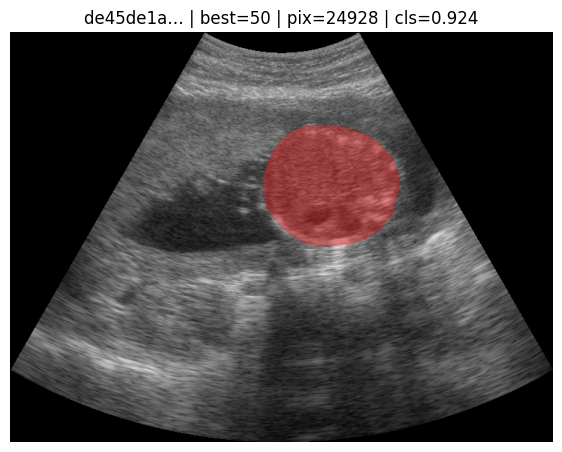

Segment ALL -> show best:  33%|███▎      | 15/45 [02:08<04:15,  8.53s/it]

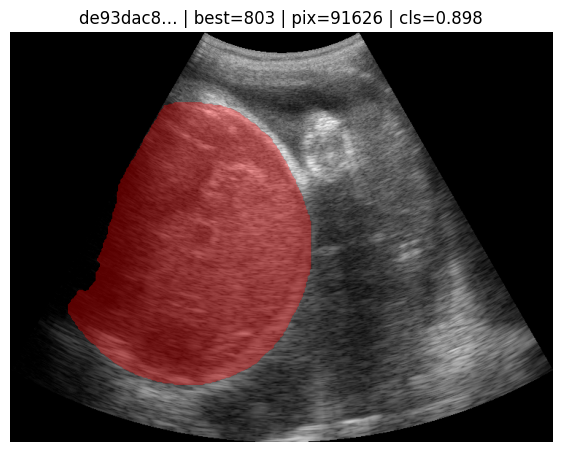

Segment ALL -> show best:  36%|███▌      | 16/45 [02:16<04:06,  8.49s/it]

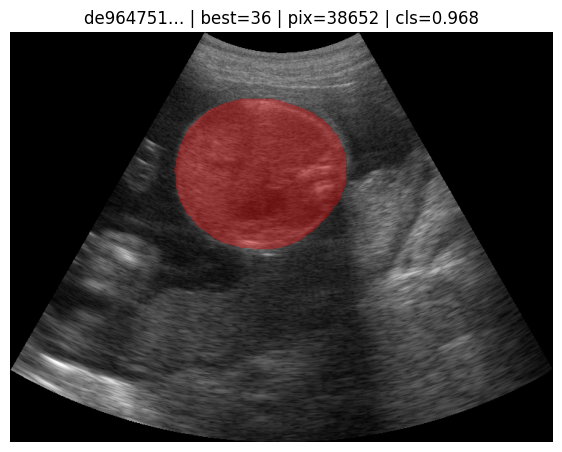

Segment ALL -> show best:  38%|███▊      | 17/45 [02:25<03:58,  8.52s/it]

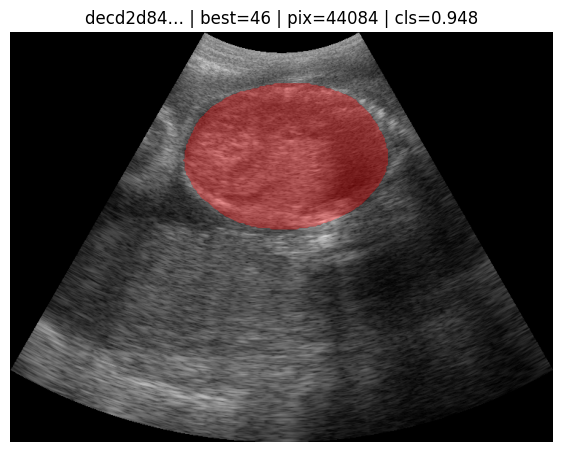

Segment ALL -> show best:  40%|████      | 18/45 [02:33<03:49,  8.50s/it]

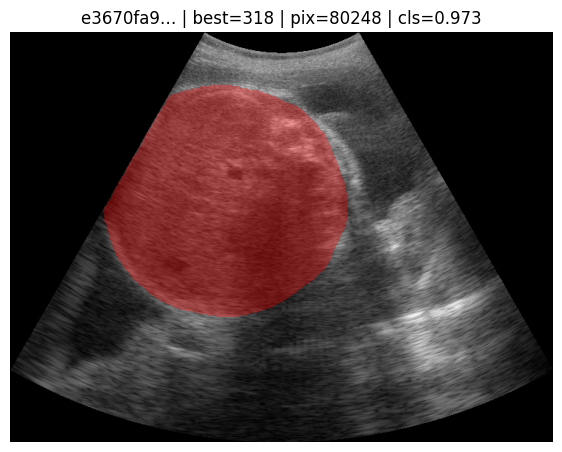

Segment ALL -> show best:  42%|████▏     | 19/45 [02:42<03:41,  8.54s/it]

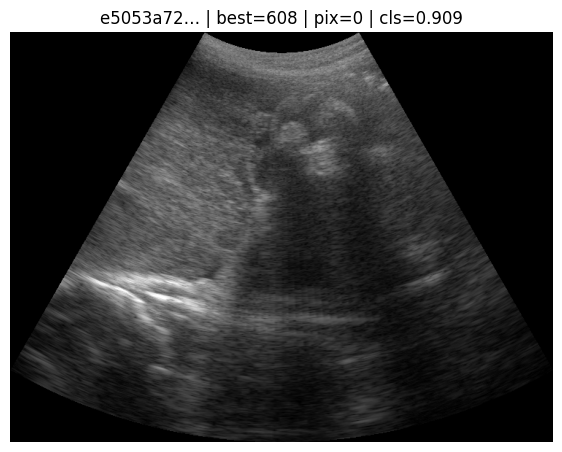

Segment ALL -> show best:  44%|████▍     | 20/45 [02:50<03:32,  8.50s/it]

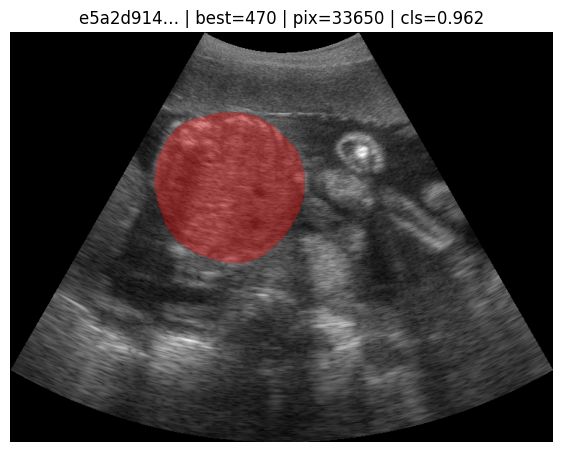

Segment ALL -> show best:  47%|████▋     | 21/45 [02:59<03:24,  8.50s/it]

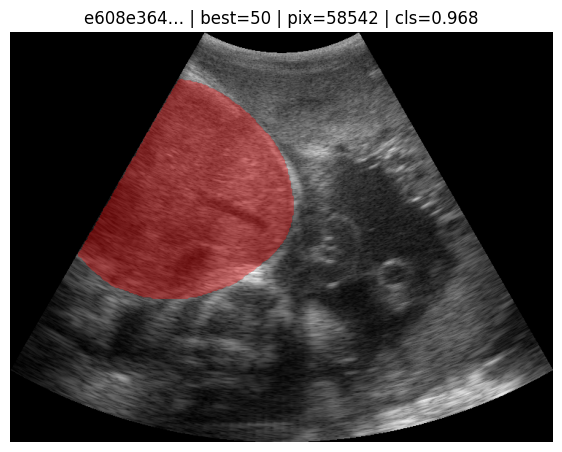

Segment ALL -> show best:  49%|████▉     | 22/45 [03:07<03:15,  8.52s/it]

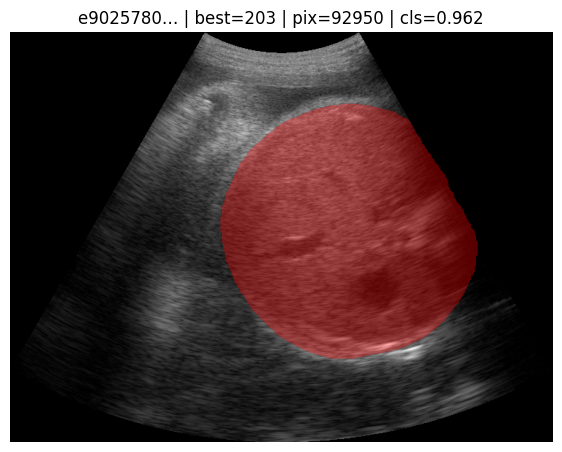

Segment ALL -> show best:  51%|█████     | 23/45 [03:16<03:07,  8.54s/it]

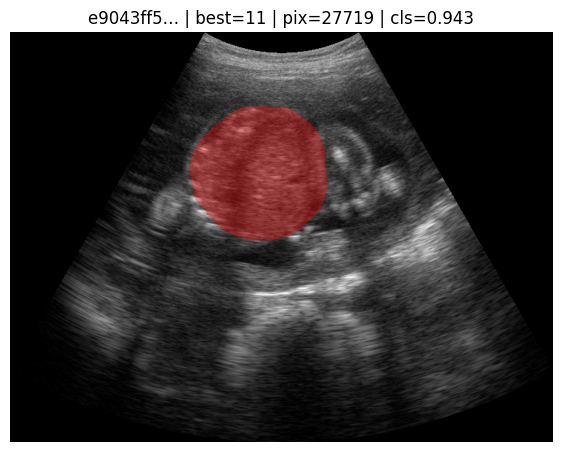

Segment ALL -> show best:  53%|█████▎    | 24/45 [03:25<02:59,  8.56s/it]

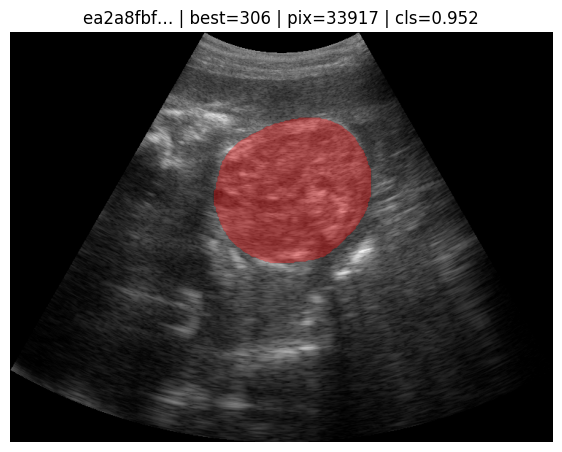

Segment ALL -> show best:  56%|█████▌    | 25/45 [03:33<02:50,  8.55s/it]

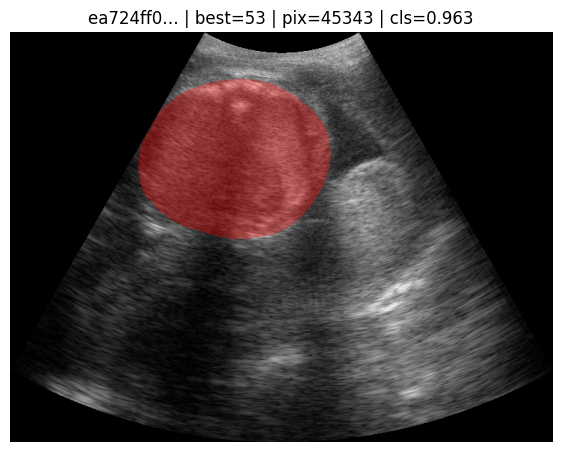

Segment ALL -> show best:  58%|█████▊    | 26/45 [03:42<02:42,  8.55s/it]

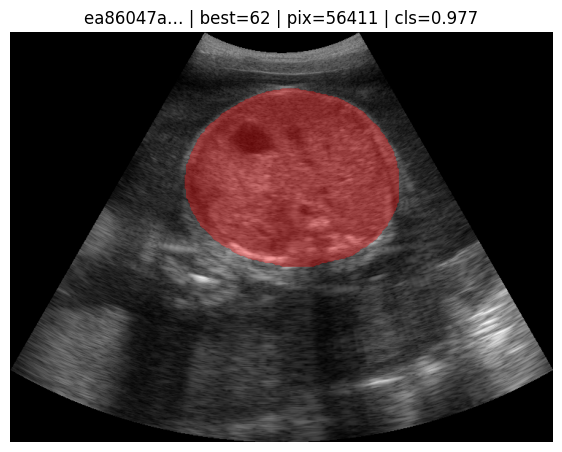

Segment ALL -> show best:  60%|██████    | 27/45 [03:51<02:37,  8.74s/it]

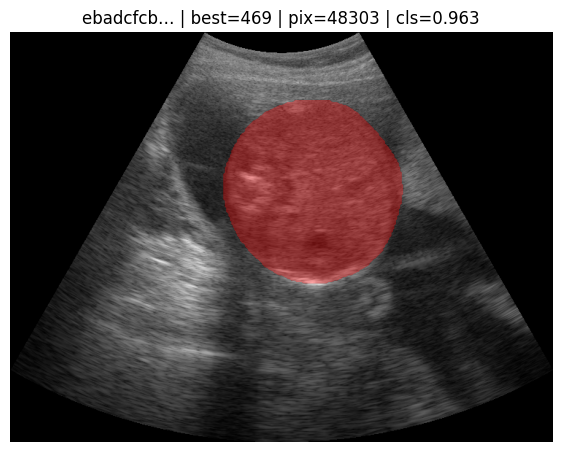

Segment ALL -> show best:  62%|██████▏   | 28/45 [03:59<02:27,  8.65s/it]

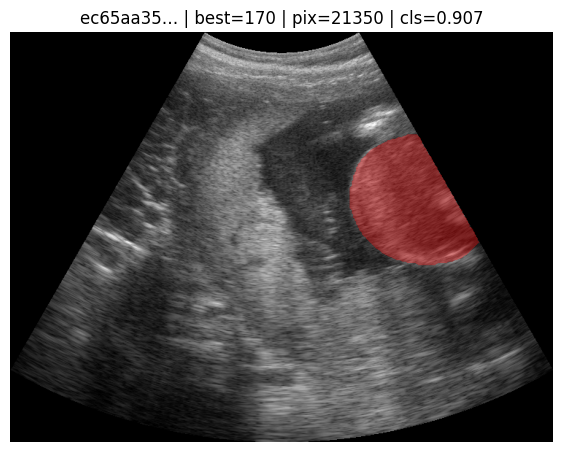

Segment ALL -> show best:  64%|██████▍   | 29/45 [04:08<02:17,  8.57s/it]

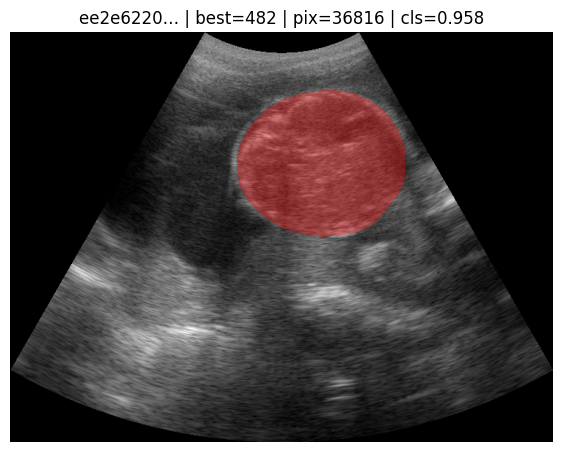

Segment ALL -> show best:  67%|██████▋   | 30/45 [04:16<02:07,  8.50s/it]

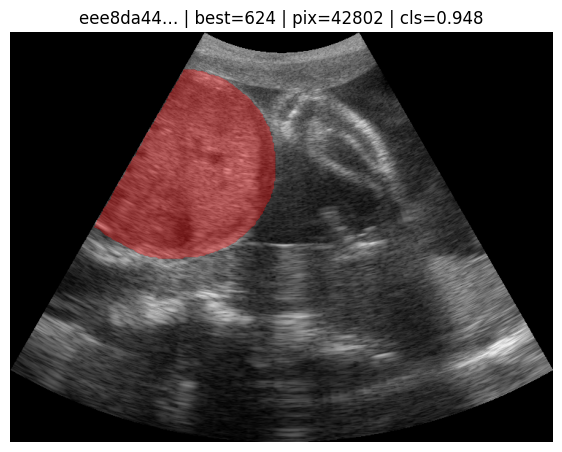

Segment ALL -> show best:  69%|██████▉   | 31/45 [04:24<01:58,  8.45s/it]

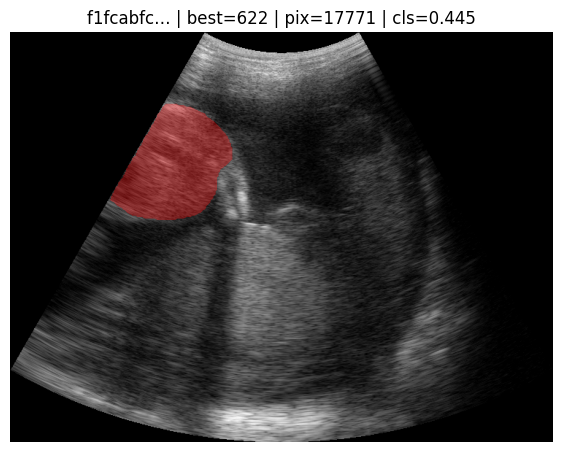

Segment ALL -> show best:  71%|███████   | 32/45 [04:33<01:49,  8.41s/it]

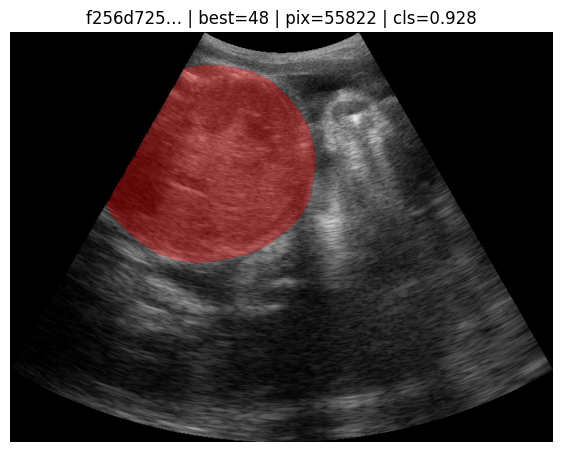

Segment ALL -> show best:  73%|███████▎  | 33/45 [04:41<01:40,  8.39s/it]

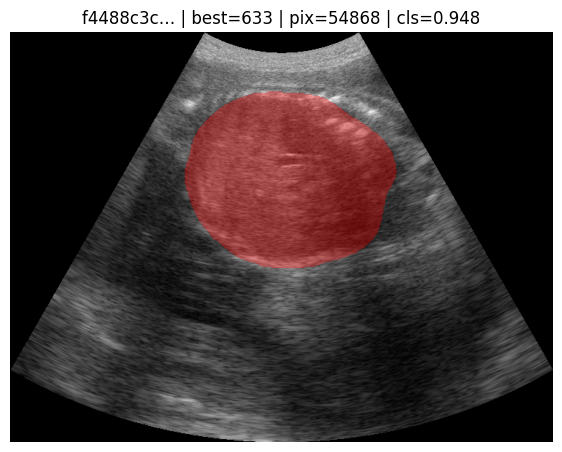

Segment ALL -> show best:  76%|███████▌  | 34/45 [04:49<01:31,  8.36s/it]

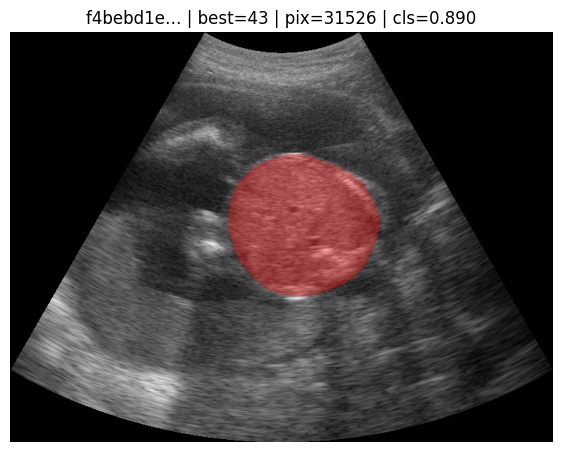

Segment ALL -> show best:  78%|███████▊  | 35/45 [04:58<01:23,  8.35s/it]

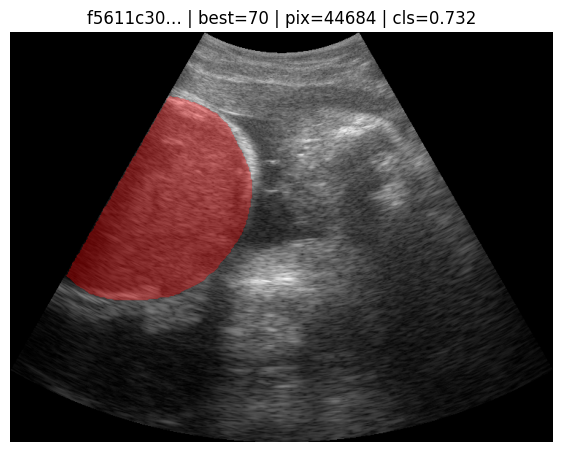

Segment ALL -> show best:  80%|████████  | 36/45 [05:06<01:15,  8.42s/it]

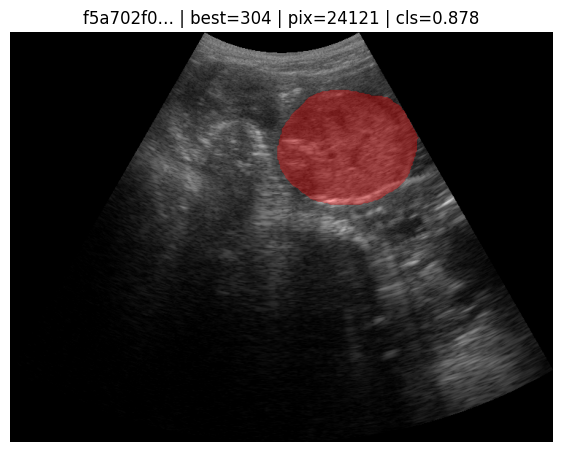

Segment ALL -> show best:  82%|████████▏ | 37/45 [05:15<01:07,  8.46s/it]

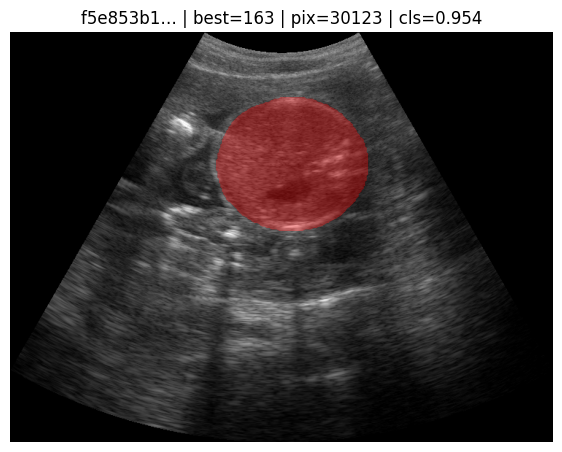

Segment ALL -> show best:  84%|████████▍ | 38/45 [05:23<00:59,  8.48s/it]

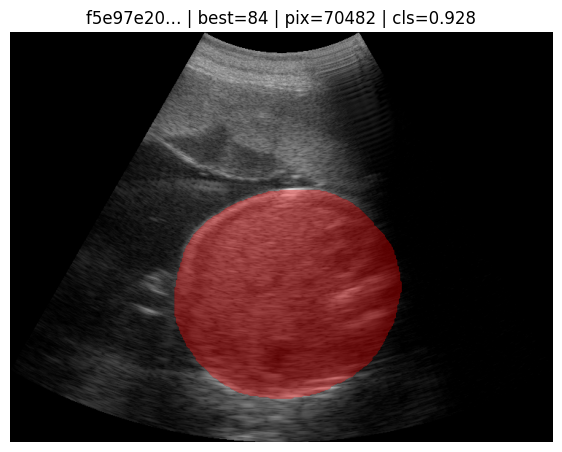

Segment ALL -> show best:  87%|████████▋ | 39/45 [05:32<00:50,  8.49s/it]

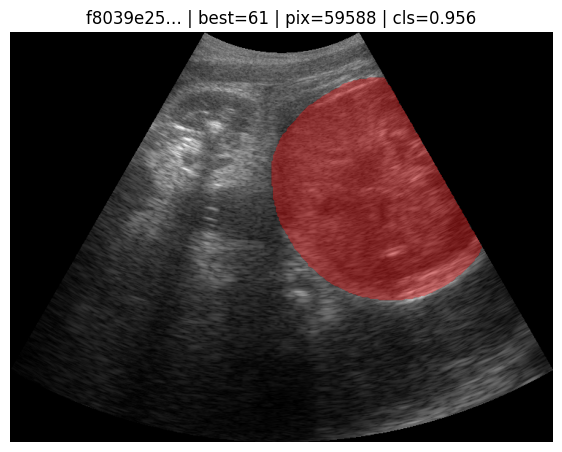

Segment ALL -> show best:  89%|████████▉ | 40/45 [05:40<00:42,  8.48s/it]

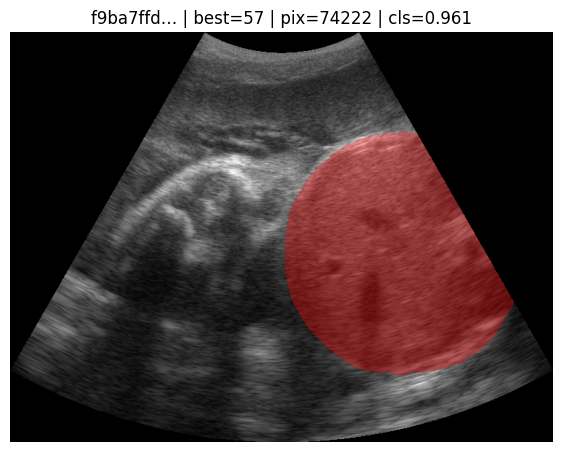

Segment ALL -> show best:  91%|█████████ | 41/45 [05:49<00:33,  8.48s/it]

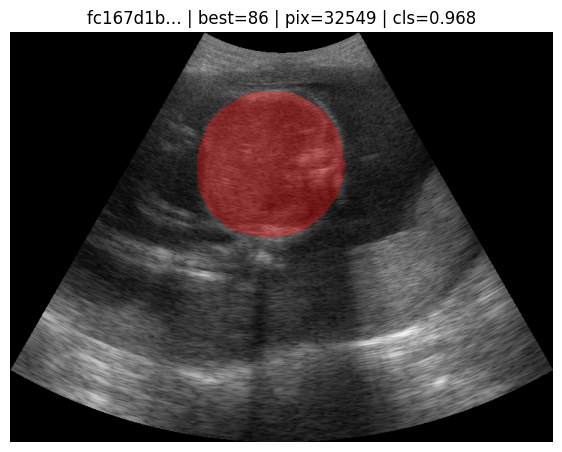

Segment ALL -> show best:  93%|█████████▎| 42/45 [05:57<00:25,  8.46s/it]

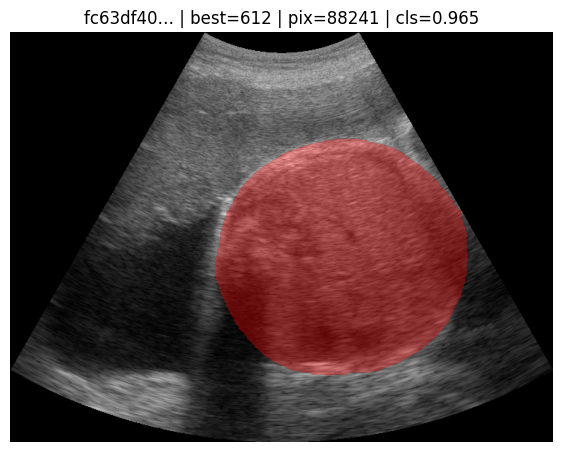

Segment ALL -> show best:  96%|█████████▌| 43/45 [06:06<00:16,  8.49s/it]

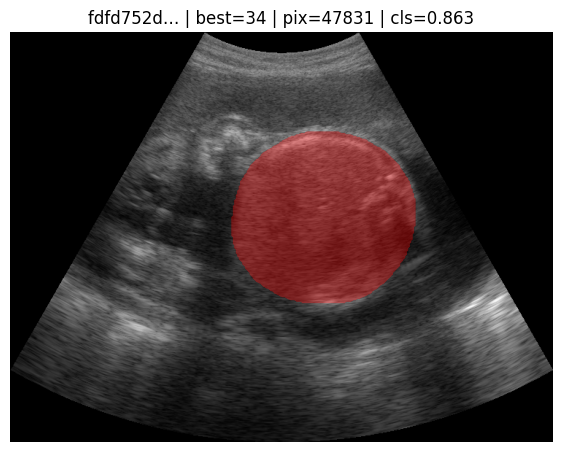

Segment ALL -> show best:  98%|█████████▊| 44/45 [06:14<00:08,  8.52s/it]

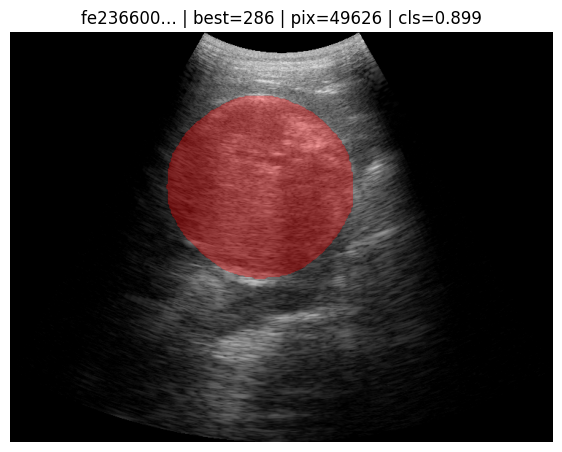

Segment ALL -> show best: 100%|██████████| 45/45 [06:23<00:00,  8.52s/it]


In [25]:
# segment_best_from_mult_npz.py
import os, csv
from pathlib import Path
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import cv2
from tqdm import tqdm
import segmentation_models_pytorch as smp

# ====== PATHS ======
NPZ_DIR   = Path(r"D:/dataset/mult_mha_to_npz")                 # <-- your full NPZs (multi-frame)
CLS_CSV   = Path(r"workdir_cls/best_frames_last45.csv")         # from your classifier
OUT_DIR   = Path(r"workdir_seg_best")                           # outputs
WEIGHTS   = Path(r"D:/acouslic-ai-cse4622/saved_weights/best_unet_seg.pth")

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# must match training input size for the segmenter
SEG_TARGET_HW = (288, 352)      # (th, tw)
SEG_THRESHOLD = 0.50
POST_KEEP     = "largest+smooth"   # 'largest' or 'largest+smooth'
POST_SHAPE    = None               # None | 'ellipse' | 'circle'

# ====== HELPERS ======
from typing import Tuple

def letterbox_params(H:int, W:int, target_hw:Tuple[int,int]):
    th, tw = target_hw
    scale = min(th / H, tw / W)
    nh, nw = int(round(H * scale)), int(round(W * scale))
    pad_h = th - nh
    pad_w = tw - nw
    pt = pad_h // 2; pb = pad_h - pt
    pl = pad_w // 2; pr = pad_w - pl
    return nh, nw, (pl, pr, pt, pb)

def apply_letterbox(img_t: torch.Tensor, target_hw:Tuple[int,int]):
    # img_t: (1,H,W) in [0,1]
    _, H, W = img_t.shape
    nh, nw, pads = letterbox_params(H, W, target_hw)
    img_t = F.interpolate(img_t.unsqueeze(0), size=(nh, nw), mode="bilinear", align_corners=False).squeeze(0)
    pl, pr, pt, pb = pads
    img_t = F.pad(img_t, (pl, pr, pt, pb), value=0.0)  # (1,th,tw)
    return img_t, (H, W, nh, nw, pads)

def undo_letterbox(mask_t: torch.Tensor, meta):
    H, W, nh, nw, (pl, pr, pt, pb) = meta
    m = mask_t[..., pt:pt+nh, pl:pl+nw]
    m = F.interpolate(m.unsqueeze(0), size=(H, W), mode="nearest").squeeze(0)
    return m

def largest_component(binary: np.ndarray, min_area: int = 0):
    b = (binary > 0).astype(np.uint8)
    num, labels, stats, _ = cv2.connectedComponentsWithStats(b, connectivity=8)
    if num <= 1: return b
    idx = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    if min_area > 0 and stats[idx, cv2.CC_STAT_AREA] < min_area:
        return np.zeros_like(b, dtype=np.uint8)
    out = np.zeros_like(b, dtype=np.uint8); out[labels == idx] = 1
    return out

def fill_holes_and_smooth(binary: np.ndarray, k_close: int = 5, k_open: int = 3):
    b = (binary > 0).astype(np.uint8)
    h, w = b.shape
    ff = b.copy()
    mask = np.zeros((h+2, w+2), np.uint8)
    cv2.floodFill(ff, mask, (0,0), 255)
    holes = (~ff.astype(bool) & ~b.astype(bool)).astype(np.uint8) * 255
    filled = (b*255) | holes
    if k_close > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_close, k_close))
        filled = cv2.morphologyEx(filled, cv2.MORPH_CLOSE, k)
    if k_open > 0:
        k = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (k_open, k_open))
        filled = cv2.morphologyEx(filled, cv2.MORPH_OPEN, k)
    return (filled > 0).astype(np.uint8)

def postprocess_mask(prob_or_bin: np.ndarray, threshold: float = SEG_THRESHOLD,
                     min_area_frac: float = 0.002, keep: str = POST_KEEP, shape: str | None = POST_SHAPE):
    m = prob_or_bin if prob_or_bin.dtype in (np.uint8, np.bool_) else (prob_or_bin >= threshold).astype(np.uint8)
    H, W = m.shape
    m = largest_component(m, min_area=int(min_area_frac * H * W))
    if keep == "largest+smooth":
        m = fill_holes_and_smooth(m)
    if shape in ("circle", "ellipse"):
        cnts, _ = cv2.findContours(m, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        if cnts:
            canvas = np.zeros_like(m, dtype=np.uint8)
            cnt = max(cnts, key=cv2.contourArea)
            if shape == "circle":
                (x, y), r = cv2.minEnclosingCircle(cnt); cv2.circle(canvas, (int(x), int(y)), int(r), 1, -1)
            else:
                if len(cnt) >= 5:
                    ell = cv2.fitEllipse(cnt); cv2.ellipse(canvas, ell, 1, -1)
                else:
                    (x, y), r = cv2.minEnclosingCircle(cnt); cv2.circle(canvas, (int(x), int(y)), int(r), 1, -1)
            m = canvas
    return m.astype(np.uint8)

def to_uint8(img01):
    v = (img01 * 255.0).clip(0,255).astype(np.uint8)
    lo, hi = np.percentile(v, [1, 99])
    if hi > lo:
        v = np.clip((v - lo) * (255.0/(hi - lo)), 0, 255).astype(np.uint8)
    return v

def draw_overlay(gray_u8, mask01, title=None):
    color = cv2.cvtColor(gray_u8, cv2.COLOR_GRAY2BGR)
    overlay = color.copy()
    overlay[mask01 > 0] = (0, 0, 255)
    cnts, _ = cv2.findContours(mask01.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(overlay, cnts, -1, (0,255,0), thickness=2)
    out = cv2.addWeighted(overlay, 0.6, color, 0.4, 0)
    if title:
        cv2.putText(out, title, (10, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 3, cv2.LINE_AA)
        cv2.putText(out, title, (10, 28), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (255,255,255), 1, cv2.LINE_AA)
    return out

# ====== MODEL ======
class UNetSeg(nn.Module):
    def __init__(self, encoder="resnet18", encoder_weights=None):
        super().__init__()
        self.unet = smp.Unet(encoder_name=encoder, encoder_weights=encoder_weights, in_channels=1, classes=1)
    def forward(self, x): return self.unet(x)

# === plug_classif_best_into_seg.py ===
import os, csv, numpy as np, torch, cv2
from pathlib import Path
from tqdm import tqdm

# --- your modules/functions reused ---
# - UNetSeg
# - apply_letterbox(img_t, target_hw) / undo_letterbox(mask_t, meta)
# - postprocess_mask(...)
# - to_uint8(...)
# (import/define them exactly as in your current file)

# ===== PATHS (edit if needed) =====

# ========= YOU ALREADY HAVE THESE =========
# - UNetSeg class
# - apply_letterbox(img_t, target_hw) and undo_letterbox(mask_t, meta)
# - postprocess_mask(prob_or_bin, threshold=..., keep="largest+smooth", ...)
# - to_uint8
# If they live in another file, import them; otherwise paste their definitions above this block.

# seg_whole_then_show_bestframe_ALL_FRAMES.py
import os, csv, numpy as np, torch, cv2
import torch.nn.functional as F
from pathlib import Path
from tqdm import tqdm
import os, csv, numpy as np, torch
import torch.nn.functional as F
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

# ========= YOU ALREADY HAVE THESE (paste/import your versions) =========
# - UNetSeg
# - apply_letterbox(img_t, target_hw) and undo_letterbox(mask_t, meta)
# - postprocess_mask(prob_or_bin, threshold=..., keep="largest+smooth", shape=None)
# - to_uint8, draw_overlay

# ========= CONFIG / PATHS =========
from typing import Tuple

from typing import Tuple

def letterbox_params(H:int, W:int, target_hw:Tuple[int,int]):
    th, tw = target_hw
    scale = min(th / H, tw / W)
    nh, nw = int(round(H * scale)), int(round(W * scale))
    pad_h, pad_w = th - nh, tw - nw
    pt, pb = pad_h // 2, pad_h - pad_h // 2
    pl, pr = pad_w // 2, pad_w - pad_w // 2
    return nh, nw, (pl, pr, pt, pb)

def apply_letterbox(img_t: torch.Tensor, target_hw:Tuple[int,int]):
    # img_t: (1,H,W) in [0,1]
    _, H, W = img_t.shape
    nh, nw, pads = letterbox_params(H, W, target_hw)
    img_t = F.interpolate(img_t.unsqueeze(0), size=(nh, nw), mode="bilinear", align_corners=False).squeeze(0)
    pl, pr, pt, pb = pads
    img_t = F.pad(img_t, (pl, pr, pt, pb), value=0.0)  # (1,th,tw)
    return img_t, (H, W, nh, nw, (pl, pr, pt, pb))

def undo_letterbox_2d(prob_2d: torch.Tensor, meta):
    # prob_2d: (th,tw) -> numpy (H,W)
    H, W, nh, nw, (pl, pr, pt, pb) = meta
    crop = prob_2d[pt:pt+nh, pl:pl+nw]                           # (nh,nw)
    full = F.interpolate(crop.unsqueeze(0).unsqueeze(0), size=(H, W), mode="nearest")
    return full.squeeze(0).squeeze(0).cpu().numpy()

# ====== CONFIG ======
NPZ_DIR   = Path(r"D:/dataset/mult_mha_to_npz")                 # your multi-frame NPZs
CLS_CSV   = Path(r"workdir_cls/best_frames_last45.csv")         # classifier outputs
BEST_PATH = Path(r"D:/acouslic-ai-cse4622/saved_weights/best_unet_seg.pth")
DEVICE    = torch.device("cuda" if torch.cuda.is_available() else "cpu")

TARGET_HW   = (288, 352)        # match seg training size
BATCH_SIZE  = 16
THRESH      = 0.50
KEEP_MODE   = "largest+smooth"  # or "largest"
SHAPE_FIT   = None              # or 'ellipse'/'circle'
RENORM_PER_FRAME = True         # OG behavior

# ===== helpers =====
def _find_npz(npz_dir: Path, uuid: str) -> Path | None:
    p = npz_dir / f"{uuid}.npz"
    if p.exists(): return p
    for q in npz_dir.glob(f"{uuid}*.npz"):
        return q
    return None

@torch.no_grad()
def segment_all_frames_og(npz_path: str, model: torch.nn.Module):
    """OG flow on ALL frames; return (pred_mask, imgs). pred_mask in {0,1}."""
    case = np.load(npz_path, mmap_mode="r")
    imgs = case["image"]                     # (T,H,W), typically 0..1 from your converter
    T, H, W = imgs.shape
    pred_mask = np.zeros((T, H, W), dtype=np.uint8)

    all_idx = np.arange(T, dtype=int)
    for start in range(0, T, BATCH_SIZE):
        end = min(start + BATCH_SIZE, T)
        ids = all_idx[start:end]

        proc_list, metas = [], []
        for k in ids:
            fr = imgs[k].astype(np.float32)
            if RENORM_PER_FRAME:
                mn, mx = fr.min(), fr.max()
                fr = (fr - mn) / (mx - mn + 1e-8)
            x = torch.from_numpy(fr)[None, ...]          # (1,H,W)
            x, meta = apply_letterbox(x, TARGET_HW)      # (1,th,tw)
            x = (x - 0.5) / 0.5                          # [-1,1]
            proc_list.append(x)
            metas.append(meta)

        batch = torch.stack(proc_list, 0).to(DEVICE)     # (B,1,th,tw)
        with torch.cuda.amp.autocast(enabled=(DEVICE.type == "cuda")):
            probs = torch.sigmoid(model(batch))          # (B,1,th,tw)

        for i, k in enumerate(ids):
            p2d   = probs[i, 0]                          # (th,tw)
            pfull = undo_letterbox_2d(p2d, metas[i])     # (H,W) numpy
            pred_mask[k] = postprocess_mask(
                pfull, threshold=THRESH,
                min_area_frac=0.002, keep=KEEP_MODE, shape=SHAPE_FIT
            )
    return pred_mask, imgs

def show_best_overlay(img_2d, mask_2d, title=None):
    """Matplotlib overlay (no saving)."""
    # ensure 0..1 for display
    fr = img_2d.astype(np.float32)
    mn, mx = fr.min(), fr.max()
    if mx > mn: fr = (fr - mn) / (mx - mn + 1e-8)
    m  = (mask_2d > 0).astype(np.uint8)

    plt.figure(figsize=(7,6))
    plt.imshow(fr, cmap="gray")
    overlay = np.zeros((m.shape[0], m.shape[1], 4), dtype=np.float32)
    overlay[m == 1] = [1, 0, 0, 0.35]  # red, 35% alpha
    plt.imshow(overlay)
    if title: plt.title(title)
    plt.axis("off")
    plt.show(block=False)
    plt.pause(0.001)   # show immediately per case

def main():
    import segmentation_models_pytorch as smp
    import torch.nn as nn

    class UNetSeg(nn.Module):
        def __init__(self, encoder="resnet18", encoder_weights=None):
            super().__init__()
            self.unet = smp.Unet(encoder_name=encoder, encoder_weights=encoder_weights,
                                 in_channels=1, classes=1)
        def forward(self, x): return self.unet(x)

    assert CLS_CSV.exists(), f"Missing classifier CSV: {CLS_CSV}"

    # seg model
    model = UNetSeg(encoder="resnet18", encoder_weights=None).to(DEVICE)
    model.load_state_dict(torch.load(str(BEST_PATH), map_location=DEVICE))
    model.eval()

    # interactive display as we go
    plt.ion()

    rows = list(csv.DictReader(open(CLS_CSV, "r", newline="")))
    print(f"Classifier cases: {len(rows)}")

    for r in tqdm(rows, desc="Segment ALL -> show best"):
        uuid     = r["case_id"]
        best_idx = int(r["best_frame_idx"])
        score    = float(r.get("score", "nan")) if "score" in r else None

        npz_path = _find_npz(NPZ_DIR, uuid)
        if npz_path is None:
            print(f"⚠️ NPZ not found for {uuid}")
            continue

        # 1) segment ALL frames with OG flow
        pred_mask, imgs = segment_all_frames_og(str(npz_path), model)

        # 2) display classifier’s best frame immediately
        T = imgs.shape[0]
        t = max(0, min(T-1, best_idx))
        ttl = f"{uuid[:8]}… | best={t} | pix={int(pred_mask[t].sum())}"
        if score is not None and not np.isnan(score):
            ttl += f" | cls={score:.3f}"
        show_best_overlay(imgs[t], pred_mask[t], title=ttl)

    # keep last figure(s) up if running as script
    plt.ioff()
    plt.show()

if __name__ == "__main__":
    main()